In [2]:
import numpy as np
from scipy import ndimage
import skimage.io
from skimage import morphology
from skimage import filters
from skimage import transform
from skimage import draw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import pandas as pd
import sys
import time
import pickle
import importlib
import scipy
import tensorflow as tf
import math

# Determining the size of the imaged pixels
As the images of algae give sizes in pixels, a microruler has been imaged so a correspondance pixel => micrometer could be established.

In [14]:
#loading of the images

data_path = os.path.join('R:','3.Masters_projects','2021_Dominic_Rebindaine','img',
                            '20211109_microruler_6mm_0.2Slide')
img_path_list = [el.numpy().decode("utf-8") for el in list(tf.data.Dataset.list_files(data_path+'\\*\\*.jpg'))]

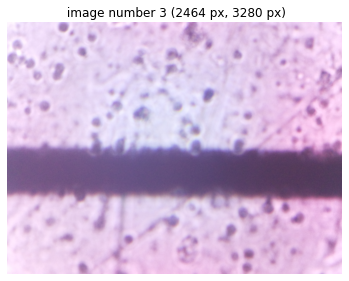

In [18]:
#test the validity of one random img
i = 3#change value to change img
img = skimage.io.imread(img_path_list[i])
im_h, im_w, im_channel = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title(' image number '+str(i)+' ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


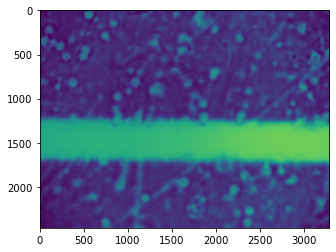

In [19]:
img_g = np.sum(img,axis=-1)
img_inv = 1-img_g/np.max(img_g)
plt.imshow(img_inv)

In [20]:
img_lp = skimage.filters.gaussian(img_inv,70)
img_hp = skimage.filters.sobel(img_lp)

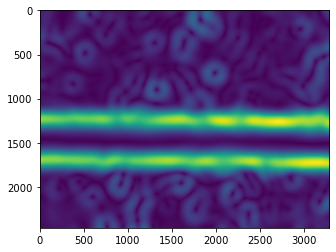

In [21]:
plt.imshow(img_hp)

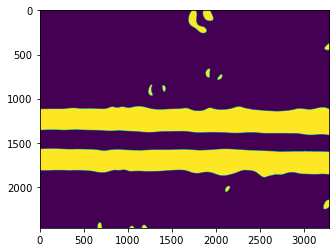

In [22]:
img_th = img_hp>0.001
plt.imshow(img_th)

In [23]:
n_angles=1000
tested_angles = np.linspace(0, np.pi, n_angles, endpoint=False)
out, angles, d = skimage.transform.hough_line(img_th,tested_angles)

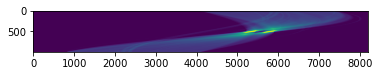

In [24]:
plt.imshow(out.T)

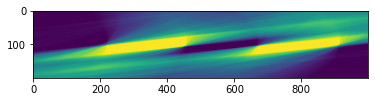

In [25]:
#zoom on the ROI
ROI = out[5000:6000,400:600].T
plt.imshow(ROI)

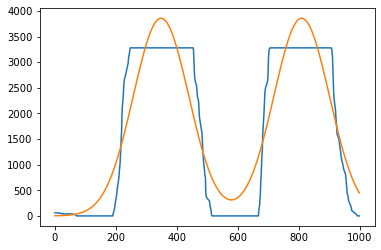

the distance between the two peaks is 461.58511420771555 pixels


In [26]:
hline=ROI[100,:]
plt.plot(hline)

#model the distribution with two gaussian:
x = np.arange(0,len(hline))
def gaussian(x,bias,var,amp):
    return amp*np.exp(-(x-bias)**2/(2*abs(var)))
def f(x,bias1,var, amp,bias2):
    return gaussian(x,bias1,var,amp)+gaussian(x,bias2,var,amp)
l = scipy.optimize.curve_fit(f,x,hline,p0=[300,30,3000,800])

plt.plot(x,f(x,l[0][0],l[0][1],l[0][2],l[0][3]))
plt.show()
print("the distance between the two peaks is "+str(abs(l[0][0]-l[0][3]))+" pixels")

In [28]:
l[0][3]

809.8679934790084

To get a statistically more relevant result, the previous steps are applied to all lines in the ROI, and are discarded if the fit is too bad. 

In [29]:
Rmin = 0.5
amp_min = 2000
var_max = 10000

In [30]:
dist = []
Rl = []
for val in ROI:
    x = np.arange(0,len(val))
    #each val represent the distances at a different angle
    try:
        l = scipy.optimize.curve_fit(f,x,val,p0=[300,30,3000,800])
        
    except:
        continue
    R = 1-np.sum((val-f(x,l[0][0],l[0][1],l[0][2],l[0][3]))**2)/np.sum((val-np.mean(val))**2)
    if R > Rmin and l[0][2]> amp_min and l[0][1]<var_max:
        dist.append(abs(l[0][0]-l[0][3]))
        Rl.append(R)

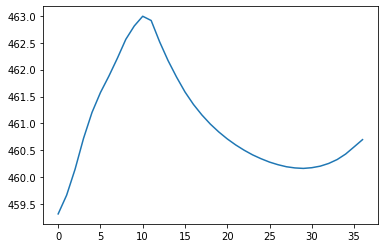

In [33]:
plt.plot(dist)
mean = np.mean(dist)
var = np.var(dist)

In [34]:
print('The distance between the two side is '+str(mean)+" with a variance of "+str(var))

The distance between the two side is 460.99360996184555 with a variance of 0.907772547493978


These steps are reproduced on all images, with the ROI and the amplitude of the gaussians manually f:

In [684]:
cROI =[[3900,5000,400,600],[5000,6100,400,600],[5000,6500,400,600],[4000,5500,400,600],[4000,5500,400,600]]
ampMin = 2700
Rmin = 0.9
var_max = 10000

The image 0 did not carry any relevant information
The mean and variance of the width on the image 1 are: 460.77240772006195 0.2431485595356968
The image 2 did not carry any relevant information


C:\Users\valla\Anaconda3\envs\tf-gpu\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The mean and variance of the width on the image 3 are: 521.755950936019 5.100105393454417
The mean and variance of the width on the image 4 are: 516.3546774509608 0.14788399135754973


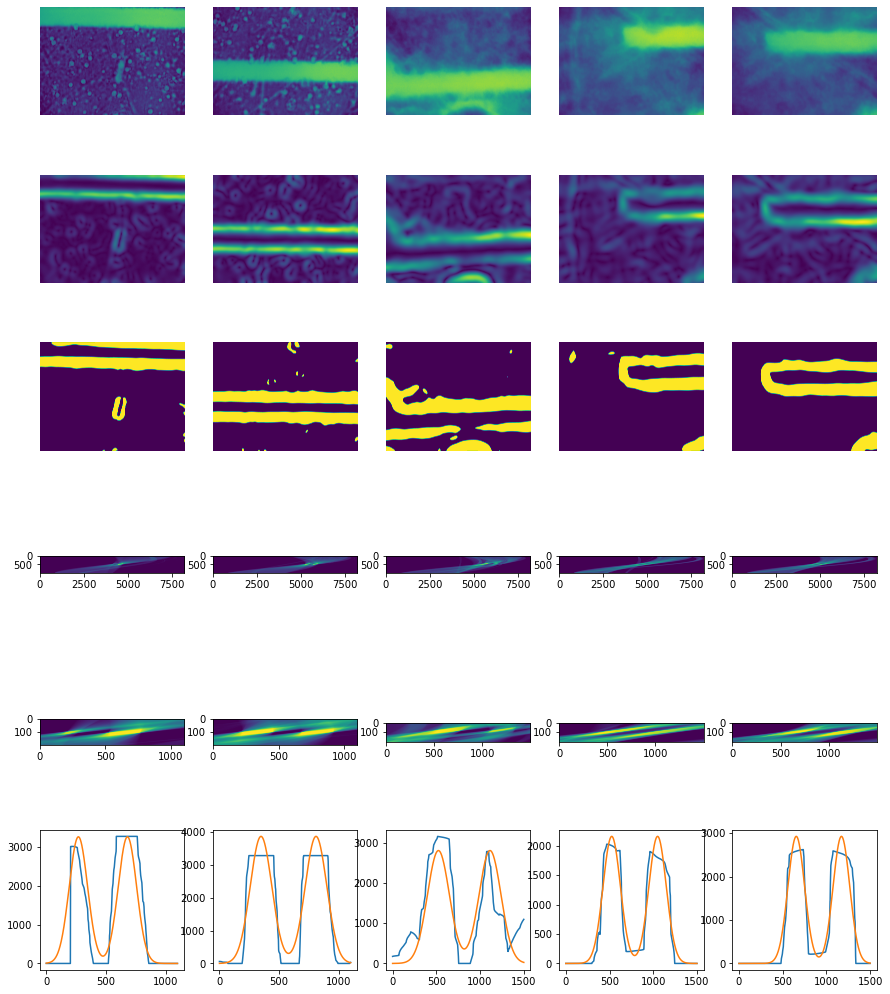

In [685]:
dist = []
fig, axs = plt.subplots(6, len(img_path_list),figsize=(15, 18))
for idx,img_path in enumerate(img_path_list):
    dist_img = []
    img = skimage.io.imread(img_path)
    img_g = np.sum(img,axis=-1)
    img_inv = 1-img_g/np.max(img_g)
    axs[0,idx].imshow(img_inv)
    axs[0,idx].axis('off')
    img_lp = skimage.filters.gaussian(img_inv,70)
    img_hp = skimage.filters.sobel(img_lp)
    axs[1,idx].imshow(img_hp)
    axs[1,idx].axis('off')
    img_th = img_hp>0.001
    axs[2,idx].imshow(img_th)
    axs[2,idx].axis('off')
    tested_angles = np.linspace(0, np.pi, 1000, endpoint=False)
    out, angles, d = skimage.transform.hough_line(img_th,tested_angles)
    axs[3,idx].imshow(out.T)
    ROI = out[cROI[idx][0]:cROI[idx][1],cROI[idx][2]:cROI[idx][3]].T
    axs[4,idx].imshow(ROI)
    x = np.arange(ROI.shape[1])
    for line, val in enumerate(ROI):
        try:
            l = scipy.optimize.curve_fit(f,x,val,p0=[len(val)/3,30,3000,2*len(val)/3])
        except:
            continue
        R = 1-np.sum((val-f(x,l[0][0],l[0][1],l[0][2],l[0][3]))**2)/np.sum((val-np.mean(val))**2)
        if line == 100:
            axs[5,idx].plot(x,val)
            axs[5,idx].plot(x,f(x,l[0][0],l[0][1],l[0][2],l[0][3]))
            
        if R > Rmin and l[0][2]> amp_min and l[0][1]<var_max:
            dist_img.append(abs(l[0][0]-l[0][3]))
    if len(dist_img)>2:
        print("The mean and variance of the width on the image "+str(idx)+" are: "+str(np.mean(dist_img))+" "+str(np.var(dist_img)))
    else:
        print("The image "+str(idx)+" did not carry any relevant information")
    dist+=(dist_img)

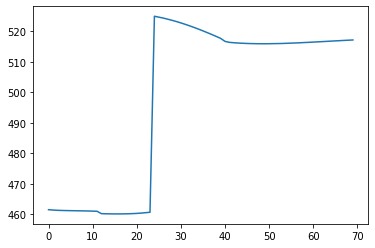

In [686]:
plt.plot(dist)

In [680]:
mean = np.mean(dist)
var = np.var(dist)
print("The thickness of the line is "+str(mean)+" with a variance of "+str(var))

The thickness of the line is 498.6098083505464 with a variance of 744.0738328971823


As the quality of the images other than the 1 is quite bad, it would probably be a better estimation to only take 461 as the pixel width. 

# Serial dilution
The a serial dilution of culture was run through the planktoscope to test the quantifying capability of the machine. They were segmented using the segmentation_from_filev2.py:

In [687]:
data_folder = os.path.join('R:','3.Masters_projects','2021_Dominic_Rebindaine','ROI',
                            'Serial Dilutions')
species = ['Tabellaria','Oocystis','Ankistrodesmus']
paths = []
for specy in species:
    paths.append(os.path.join(data_folder,specy))

In [719]:
i = 2
base_path = paths[i]

In [720]:
odj_df = None
n_obj = np.zeros((6,2,100))
n_roi = np.zeros((6,2))
for idx_t, tube in enumerate(os.listdir(base_path)):
    path = os.path.join(base_path, tube)
    for idx_r, run in enumerate(os.listdir(path)):
        
        path_full = os.path.join(path,run)
        n_roi[idx_t,idx_r]=len(os.listdir(path_full))
        #for idx_f, obj in enumerate(os.listdir(path_full)):
            #with open(os.path.join(path_full,obj), 'rb') as f:
                #objects = pickle.load(f)
            #if obj_df is None:
                #obj_df = objects
            #else:
                #obj_df = obj_df.append(objects)
            #n_obj[idx_t,idx_r,idx_f]=len(objects)
                
if species[i]=='Ankistrodesmus':
    #this aquisition only has 8 images instead of 100
    n_roi[0,1]*=100/8

check the distribution of the number of object per frame and per acquisition:

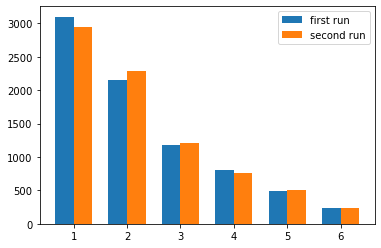

In [721]:
x = np.arange(1,n_roi.shape[0]+1)
width = 0.35
plt.bar(x-width/2,n_roi[:,0],width)
plt.bar(x+width/2,n_roi[:,1],width)
#plt.xticks(x, label_name,rotation='vertical')
plt.legend(['first run','second run'])
plt.show()

In [722]:
y = np.mean(n_roi,axis=-1)
def f(x,a,b):
    return a/(2**(x-1))+b
l = scipy.optimize.curve_fit(f,x,y)
y_est = f(x,l[0][0],l[0][1])


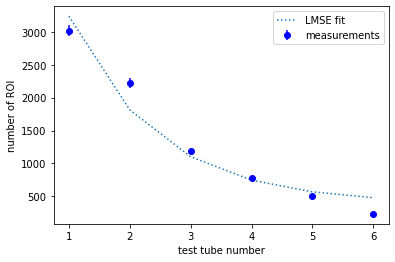

In [723]:
n_acqu = n_roi
err = np.std(n_roi,axis=-1)

plt.errorbar(x,y, yerr = err,fmt='bo')
plt.plot(x,y_est,linestyle='dotted')
plt.legend(["LMSE fit","measurements"])
plt.ylabel("number of ROI")
plt.xlabel("test tube number")
plt.show()

In [724]:
Rsquare = 1-np.sum((y-y_est)**2)/np.sum((y-np.mean(y))**2)
print("R = "+str(Rsquare)+" with an offset of "+str(l[0][1]))

R = 0.951077315354841 with an offset of 391.54105215582484


As one can see, the coefficient of regression is quite good when the fit is allowed to reach an offset. This offset can be explained by the impurity and dirt present in the water or in the tubes. The previous method was applied to 3 different species:

For the species Tabellaria, R = 0.8265388848710452 with an offset of 61.629353233963094
For the species Oocystis, R = 0.9755261734548173 with an offset of 43.81592039810333
For the species Ankistrodesmus, R = 0.951077315354841 with an offset of 391.54105215582484


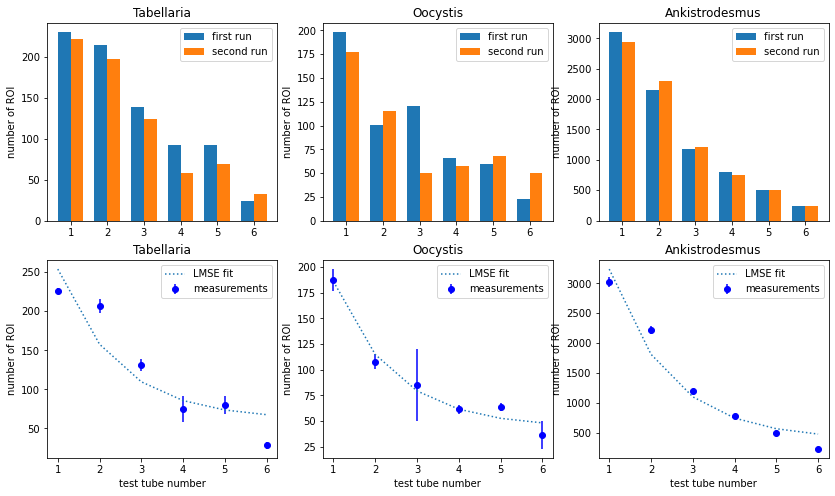

In [732]:
fig, axs = plt.subplots(2,len(paths),figsize=(14,8))
for i,base_path in enumerate(paths):
    odj_df = None
    n_obj = np.zeros((6,2,100))
    n_roi = np.zeros((6,2))
    for idx_t, tube in enumerate(os.listdir(base_path)):
        path = os.path.join(base_path, tube)
        for idx_r, run in enumerate(os.listdir(path)):
            path_full = os.path.join(path,run)
            n_roi[idx_t,idx_r]=len(os.listdir(path_full))
    
    if species[i]=='Ankistrodesmus':
        #this aquisition only has 8 images instead of 100
        n_roi[0,1]*=100/8
        

    x = np.arange(1,n_roi.shape[0]+1)
    width = 0.35
    
    axs[0,i].bar(x-width/2,n_roi[:,0],width)
    axs[0,i].bar(x+width/2,n_roi[:,1],width)
    #plt.xticks(x, label_name,rotation='vertical')
    axs[0,i].legend(['first run','second run'])
    axs[0,i].set_ylabel("number of ROI")
    axs[0,i].set_title(species[i])
    y = np.mean(n_roi,axis=-1)
    l = scipy.optimize.curve_fit(f,x,y)
    y_est = f(x,l[0][0],l[0][1])
    
    err = np.std(n_roi,axis=-1)

    axs[1,i].errorbar(x,y, yerr = err,fmt='bo')
    axs[1,i].plot(x,y_est,linestyle='dotted')
    axs[1,i].legend(["LMSE fit","measurements"])
    axs[1,i].set_ylabel("number of ROI")
    axs[1,i].set_xlabel("test tube number")
    axs[1,i].set_title(species[i])
    Rsquare = 1-np.sum((y-y_est)**2)/np.sum((y-np.mean(y))**2)
    print("For the species "+species[i]+", R = "+str(Rsquare)+" with an offset of "+str(l[0][1]))
plt.show()